<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/part14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Shortcut connections

Also known as skip or residual connections.

Shortcut connections were first proposed in the field of computer vision to solve the problem of vanishing gradients.

Gradients become progressively smaller as they propagate backward, making it difficult to train earlier layers. Convergence is delayed and learning becomes stagnant.

Shortcut connections create an alternative path for the gradient to flow by skipping one or more layers.

This is achieved by adding the output of one layer to the output of the later layer.

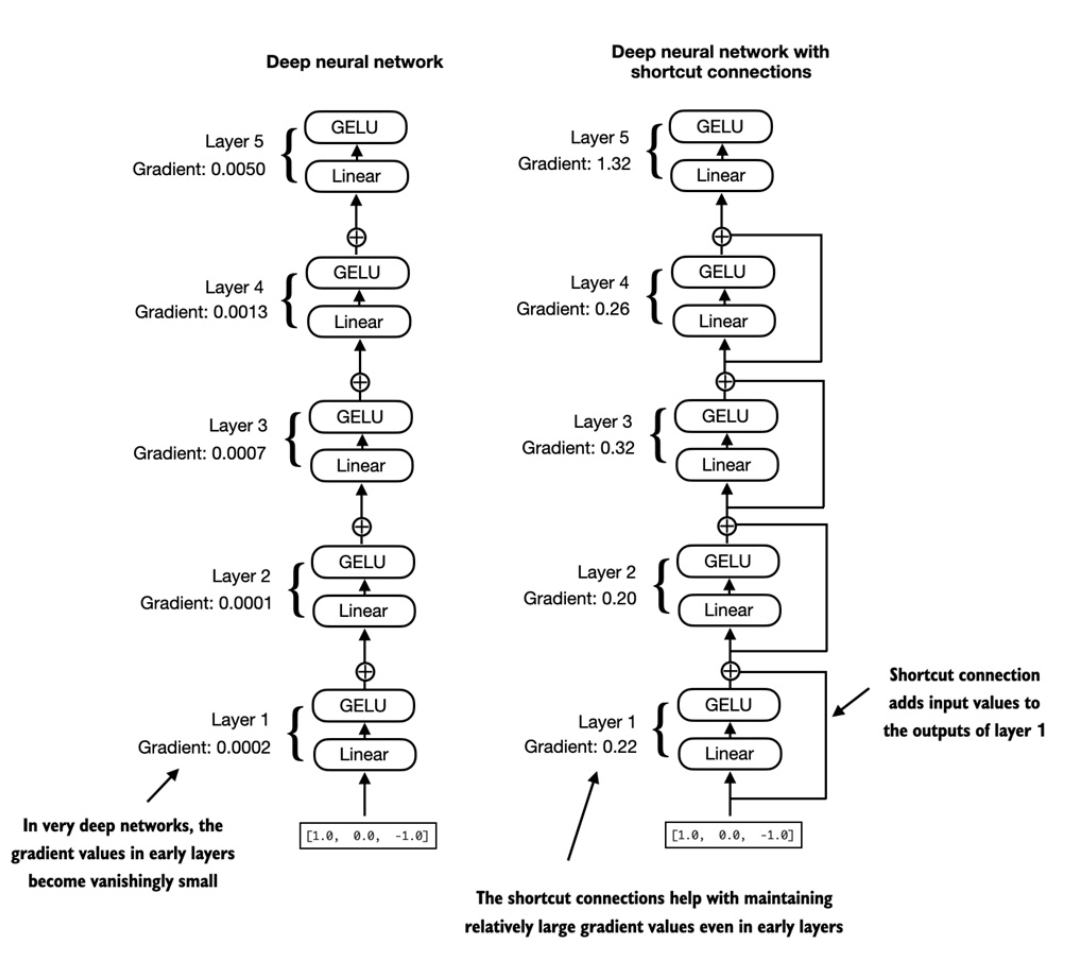

In above image, gradient is nothing but the mean of all the gradient values for that level.

YL_1 = f(yL) + yL

dL/dyL = = dL/dYL_1 (dYL_1 / dYL)


dL/dyL = = dL/dYL_1 ((df(yL) / dYL) + 1)

df(yL) / dYL -> can goes to zero because of vanicing gradient problem but +1 keeps the gradient flowing through the newtwork.

Paper - https://arxiv.org/abs/1712.09913

In [44]:
import torch
import torch.nn as nn

class GELU(nn.Module):
  def __init__(self) -> None:
    super().__init__()

  def forward(self, x):
    # approx GeLu function
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

In [45]:
class ExampleDeepNeuralNetwork(nn.Module):

  # layers size is num of neurons in each level
  # use_shortcut boolean flag
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)

      # check if shortcut can be applied
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output

    return x

In [46]:
layer_sizes = [3,3,3,3,3,1]
torch.manual_seed(123)

sample_input = torch.tensor([[1., 0., -1.]])

model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
print(model_without_shortcut(sample_input))

torch.manual_seed(123)

sample_input1 = torch.tensor([[1., 0., -1.]])
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print(model_with_shortcut(sample_input1))

tensor([[0.0610]], grad_fn=<MulBackward0>)
tensor([[0.7669]], grad_fn=<MulBackward0>)


#### Why use of torch.manual_seed() again required?

Both models are initialized one after another using the same global seed, but the second model’s weights are different because the random number generator has already advanced when the first model was created.

In other words:

torch.manual_seed(123) fixes the starting state of randomness.

The first model consumes random numbers for its layer weights.

By the time the second model is created, the random generator has moved forward — it won’t reuse the same weights.

So, you are not comparing “same weights with vs without shortcut” — you’re comparing two differently initialized networks, which is why the output difference can seem arbitrary or confusing.

In [47]:
def print_gradients(model, x):
  # Forward pass
  output = model(x)
  target = torch.tensor([[0.]])

  # Calculate loss based on how close the target
  # and output are
  loss = nn.MSELoss()
  loss = loss(output, target)

  # Backward pass to calculate the gradients
  loss.backward()

  for name, param in model.named_parameters():
      if 'weight' in name:
          # Print the mean absolute gradient of the weights
          print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [48]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [49]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


As we can see, based on the output, the last layer (layers.4) still has a larger gradient than the other layers.

However, the gradient value stabilizes as we progress towards the
first layer (layers.0) and doesn't shrink to a vanishingly small value.

In conclusion, shortcut connections are important for overcoming the limitations posed by the vanishing gradient problem in deep neural networks.

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective
training by ensuring consistent gradient flow across layers when we train the GPT model